# **ch7 추천엔진 과 모델의 평가**
- 머신러닝과 통계 [**(자료다운)**](http://acornpub.co.kr/book/statistics-machine-learning) 자료 다운로드
- movielens 데이터를 사용하여 분석합니다

## **1 데이터 불러오기**
- **CSV 영화 데이터** 불러오기
- 1개의 테이블로 묶고, 이를 **user/ movie Pivot Table로** 변환
- 연산의 용이성을 위해 **numpy Matrix로** 변환

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ratings = pd.read_csv("data/ml-latest-small/ratings.csv")
print (ratings.head(2))
movies = pd.read_csv("data/ml-latest-small/movies.csv")
print (movies.head(2))

   userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
   movieId             title                                       genres
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy
1        2    Jumanji (1995)                   Adventure|Children|Fantasy


In [2]:
# 영화제목과 평점정보를 1개의 DataFrame으로 묶음
ratings = pd.merge(ratings[['userId', 'movieId', 'rating']], 
                   movies[['movieId', 'title']],
                   how='left', left_on='movieId', right_on='movieId')
ratings.head(3)

,userId,movieId,rating,title
0,1,31,2.5,Dangerous Minds (1995)
1,1,1029,3.0,Dumbo (1941)
2,1,1061,3.0,Sleepers (1996)


In [3]:
# 영화명 필드, 사용자 인덱스 Pivot Table을 생성합니다
rp = ratings.pivot_table(columns = ['movieId'], 
                         index   = ['userId'], values = 'rating')
rp = rp.fillna(0)
rp.head(3)

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# 연산이 용이하도록 numpy matrix로 변환합니다
rp_mat = rp.values # as_matrix()
rp_mat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.]])

## **2 내용 기반의 협업 필터링** (Cosin 유사도 측정)
### **01 User Based Table** (사용자 Cosin 유사도 측정)
- **Numpy Matrix** 간의 유사도를 측정합니다
- 뒤에 이어질 **내용기반 필터링** 방법에서도 동일하게 적용됩니다
- **Pivot Table** 의 **Cosin 유사도를** 측정하다보니 시간이 오래걸림
- from **sklearn.metrics.pairwise** import **linear_kernel** 가 더 빠르더라

In [9]:
# The cosine of the angle between them is about 0.822.
from scipy.spatial.distance import cosine
a = np.asarray([2, 1, 0, 2, 0, 1, 1, 1])
b = np.asarray([2, 1, 1, 1, 1, 0, 1, 1])
print ("A 과 B 행렬의 Cosin 유사도 : {:.3f}".format(1-cosine(a, b)))

A 과 B 행렬의 Cosin 유사도 : 0.822


In [10]:
%%time
# User similarity matrix
m, n      = rp.shape
mat_users = np.zeros((m, m))
for i in range(m):
    for j in range(m):
        if i != j: 
            mat_users[i][j] = (1-cosine(rp_mat[i,:], rp_mat[j,:]))
        else: 
            mat_users[i][j] = 0.
            
pd_users = pd.DataFrame(mat_users, index=rp.index, columns=rp.index )
print(pd_users.head(2))

userId       1         2         3         4         5         6         7    \
userId                                                                         
1       0.000000  0.000000  0.000000  0.074482  0.016818  0.000000  0.083884   
2       0.000000  0.000000  0.124295  0.118821  0.103646  0.000000  0.212985   
3       0.000000  0.124295  0.000000  0.081640  0.151531  0.060691  0.154714   
4       0.074482  0.118821  0.081640  0.000000  0.130649  0.079648  0.319745   
5       0.016818  0.103646  0.151531  0.130649  0.000000  0.063796  0.095888   

userId       8         9         10     ...          662       663       664  \
userId                                  ...                                    
1       0.000000  0.012843  0.000000    ...     0.000000  0.000000  0.014474   
2       0.113190  0.113333  0.043213    ...     0.477306  0.063202  0.077745   
3       0.249781  0.134475  0.114672    ...     0.161205  0.064198  0.176134   
4       0.191013  0.030417  0.137186   

In [11]:
# 사용자 기반 유사도 측정
def topn_simusers(uid=16, n=5):
    users      = pd_users.loc[uid, :].sort_values(ascending=False)
    topn_users = users.iloc[:n, ]
    topn_users = topn_users.rename('score')    
    print ("Similar users as user:", uid)
    return pd.DataFrame(topn_users)

# 17번 사용자와 유사한 10명의 ID 정보를 출력
print(topn_simusers(uid=17, n=10))

Similar users as user: 17
           score
userId          
596     0.379128
23      0.374641
355     0.329605
430     0.328872
608     0.319770
509     0.319313
105     0.309477
457     0.308201
15      0.307179
461     0.299035


In [12]:
# 사용자가 선호하는 영화목록을 출력하는 함수
def topn_movieratings(uid=355, n_ratings=10):    
    uid_ratings = ratings.loc[ratings['userId'] == uid]
    uid_ratings = uid_ratings.sort_values(by='rating', ascending=[False])
    print ("Top {} movie ratings of user: {}".format(n_ratings, uid))
    return uid_ratings.iloc[:n_ratings, ]    

# 596번 사용자가 선호하는 영화목록 10개
print(topn_movieratings(uid=596, n_ratings=10))

Top 10 movie ratings of user: 596
       userId  movieId  rating                                   title
89645     596     4262     5.0                         Scarface (1983)
89732     596     6874     5.0                Kill Bill: Vol. 1 (2003)
89353     596      194     5.0                            Smoke (1995)
89546     596     2329     5.0               American History X (1998)
89453     596     1193     5.0  One Flew Over the Cuckoo's Nest (1975)
89751     596     8132     5.0                        Gladiator (1992)
89579     596     2858     5.0                  American Beauty (1999)
89365     596      296     5.0                     Pulp Fiction (1994)
89587     596     2959     5.0                       Fight Club (1999)
89368     596      318     5.0        Shawshank Redemption, The (1994)


### **02 Item Based Table** (영화 Cosin 유사도 측정)
- **Numpy Matrix** 간의 유사도를 측정합니다
- 뒤에 이어질 **내용기반 필터링** 방법에서도 동일하게 적용됩니다
- **Pivot Table** 의 **Cosin 유사도를** 측정하다보니 시간이 오래걸림
- from **sklearn.metrics.pairwise** import **linear_kernel** 가 더 빠르더라

In [13]:
# cosine_sim 코싸인 유사도 행렬
# TF-IDF Vectorizer간 Dot Product 계산시 Cosine Similarity Score 제공
from sklearn.metrics.pairwise import linear_kernel
mat_movies = linear_kernel(rp_mat, rp_mat)
mat_movies

array([[ 145.  ,    0.  ,    0.  , ...,   16.  ,    0.  ,    9.  ],
       [   0.  ,  985.  ,  101.5 , ...,   16.  ,  119.  ,  152.  ],
       [   0.  ,  101.5 ,  677.  , ...,   44.5 ,   79.  ,  189.5 ],
       ...,
       [  16.  ,   16.  ,   44.5 , ...,  446.  ,   20.  ,   77.  ],
       [   0.  ,  119.  ,   79.  , ...,   20.  ,  494.  ,  217.5 ],
       [   9.  ,  152.  ,  189.5 , ...,   77.  ,  217.5 , 1831.25]])

In [14]:
from scipy.spatial.distance import cdist
mat_movies = cdist(rp_mat, rp_mat)
mat_movies.shape

(671, 671)

In [15]:
from sklearn.metrics import pairwise_distances
mat_movies = pairwise_distances(rp_mat, metric='manhattan')
mat_movies.shape

(671, 671)

In [16]:
# %%time
# # 개별 영화간 유사도 측정
# mat_movies = np.zeros((n, n))
# for i in range(n):
#     for j in range(n):
#         if i != j: mat_movies[i,j] = (1-cosine(rp_mat[:,i], rp_mat[:,j]))
#         else:      mat_movies[i,j] = 0.

# # 대략 56min 5s 소요
# print(mat_movies.shape)
# pd_movies = pd.DataFrame(mat_movies, index=rp.columns ,columns=rp.columns )
# pd_movies.to_csv('data/pd_movies.csv', sep=',')

In [17]:
pd_movies = pd.read_csv("data/pd_movies.csv",index_col='movieId')

# Finding similar movies
def topn_simovies(mid = 588,n=15):
    mid_ratings = pd_movies.loc[mid,:].sort_values(ascending = False)
    topn_movies = pd.DataFrame(mid_ratings.iloc[:n,])
    topn_movies['index1'] = topn_movies.index
    topn_movies['index1'] = topn_movies['index1'].astype('int64')
    topn_movies = pd.merge(topn_movies, movies[['movieId','title']],
                           how='left', left_on='index1', right_on='movieId')
    print ("Movies similar to movie id: {}, {}, are".format(
        mid, 
        movies['title'][movies['movieId']==mid].to_string(index=False)))
    del topn_movies['index1']
    return topn_movies

# 589번 사용자가 유사한 영화목록 15개 출력
print (topn_simovies(mid=589, n=15))

Movies similar to movie id: 589, Terminator 2: Judgment Day (1991), are
         589  movieId                                              title
0   0.702256      480                               Jurassic Park (1993)
1   0.636392     1240                             Terminator, The (1984)
2   0.633428      110                                  Braveheart (1995)
3   0.619415      356                                Forrest Gump (1994)
4   0.614814      377                                       Speed (1994)
5   0.605887      380                                   True Lies (1994)
6   0.604555      457                               Fugitive, The (1993)
7   0.591071      593                   Silence of the Lambs, The (1991)
8   0.579325      367                                   Mask, The (1994)
9   0.577299     1036                                    Die Hard (1988)
10  0.576275      592                                      Batman (1989)
11  0.568341      296                               

## **3 ALS** (Alternating Least Squares) **를 사용한 협업 필터링**
### **01 희소행렬의 생성**
- **평점 희소행렬을** (데이터 유무로 0,1) 사용하여 연산을 진행 합니다
- 연산 및 연산후 정렬을 쉽게 연산할 수 있도록 도와주는 행렬을 활용합니다

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ratings = pd.read_csv("data/ml-latest-small/ratings.csv")
# movies  = pd.read_csv("data/ml-latest-small/movies.csv")
# rp = ratings.pivot_table(columns=['movieId'], index=['userId'], values='rating')
# rp = rp.fillna(0)
A = rp.values
print ("\nShape of Original Sparse Matrix",  A.shape)
A


Shape of Original Sparse Matrix (671, 9066)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.]])

In [19]:
# 0.5~5 평점이 존재하면1, 없으면 0의 희소행렬을 생성
W = A > 0.5
W [W == True]  = 1
W [W == False] = 0
W = W.astype(np.float64,copy=False)
W

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [20]:
# W 와 반대조건의 Table을 생성
# 예측된 평가행렬을 W_pred 와 곱하면 0 이 되도록 만들기 위함
# 연산 후 내림차순으로 정렬을 쉽게 도와주는 행렬
W_pred = A < 0.5
W_pred[W_pred==True]  = 1
W_pred[W_pred==False] = 0
W_pred = W_pred.astype(np.float64, copy=False)
np.fill_diagonal(W_pred, val=0)
W_pred

array([[0., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [0., 1., 1., ..., 1., 1., 1.],
       [0., 1., 1., ..., 1., 1., 1.]])

### **02 근사행렬을 활용한 예측모델 생성**
- **평점 희소행렬을** (데이터 유무로 0,1) 사용하여 연산을 진행 합니다
- **연산** 및 **연산 후 정렬을** 쉽게 연산할 수 있도록 도와주는 행렬을 활용합니다

In [21]:
# Parameters
m, n         = A.shape
n_iterations = 70   # 학습을 위한 반복횟수
n_factors    = 100   # 잠재요인
lmbda        = 0.1   # 학습률

X = 5 * np.random.rand(m, n_factors)
Y = 5 * np.random.rand(n_factors, n)

# RMSE 오차계산 함수를 정의합니다
def get_error(A, X, Y, W):
    return np.sqrt(np.sum((W * (A - np.dot(X, Y)))**2)/np.sum(W))

errors = []
for itr in range(n_iterations):
    X = np.linalg.solve(np.dot(Y,Y.T) + lmbda*np.eye(n_factors), np.dot(Y,A.T)).T
    Y = np.linalg.solve(np.dot(X.T,X) + lmbda*np.eye(n_factors), np.dot(X.T,A))    
    if itr % 10 == 0:
        print("{:3} 반복완료 RMSE is: {:.4f}".format(itr,get_error(A,X,Y,W)))
    errors.append(get_error(A, X, Y, W))

# 최종 예측행렬을 생성 합니다
A_hat = np.dot(X, Y)
print ("영화폄점 최종 모델의 RMSE: ",get_error(A,X,Y,W))    

  0 반복완료 RMSE is: 3.2415
 10 반복완료 RMSE is: 1.7181
 20 반복완료 RMSE is: 1.7081
 30 반복완료 RMSE is: 1.7042
 40 반복완료 RMSE is: 1.7020
 50 반복완료 RMSE is: 1.7007
 60 반복완료 RMSE is: 1.6997
영화폄점 최종 모델의 RMSE:  1.6990904715763828


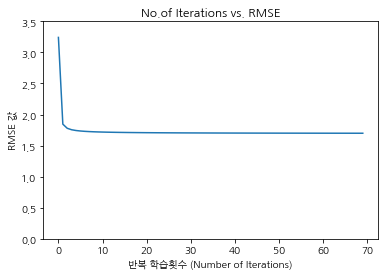

In [22]:
%matplotlib inline
from matplotlib import rc
from matplotlib import pyplot as plt
rc('font', family=['NanumGothic','Malgun Gothic'])

plt.plot(errors)
plt.ylim([0, 3.5])
plt.xlabel("반복 학습횟수 (Number of Iterations)")
plt.ylabel("RMSE 값")
plt.title("No.of Iterations vs. RMSE")
plt.show()

In [23]:
# 위에서 반복학습한 행렬을 곱하여 최종 예측행렬을 출력합니다
def print_recommovies(uid=315, n_movies=15, pred_mat=A_hat, wpred_mat=W_pred):
    pred_recos   = pred_mat * wpred_mat
    pd_predrecos = pd.DataFrame(pred_recos, index=rp.index ,columns=rp.columns)
    pred_ratings = pd_predrecos.loc[uid,:].sort_values(ascending = False)
    pred_topratings = pred_ratings[:n_movies,]
    pred_topratings = pred_topratings.rename('pred_ratings')  
    pred_topratings = pd.DataFrame(pred_topratings)
    pred_topratings['index1'] = pred_topratings.index
    pred_topratings['index1'] = pred_topratings['index1'].astype('int64')
    pred_topratings = pd.merge(pred_topratings,movies[['movieId','title']],how = 'left',left_on ='index1' ,right_on = 'movieId')
    del pred_topratings['index1']    
    print ("\nTop",n_movies,"movies predicted for the user:",uid," based on collaborative filtering\n")
    return pred_topratings

# 355번 사용자가 선호하는 영화목록 10편을 출력합니다
# 연산에 활용할 예측행렬, 희소행렬을 입력합니다
print_recommovies(uid=355, n_movies=10, pred_mat=A_hat, wpred_mat=W_pred)


Top 10 movies predicted for the user: 355  based on collaborative filtering



,pred_ratings,movieId,title
0,2.389161,1923,There's Something About Mary (1998)
1,2.323406,1213,Goodfellas (1990)
2,2.179170,5010,Black Hawk Down (2001)
3,2.165468,1197,"Princess Bride, The (1987)"
4,1.937502,8798,Collateral (2004)
5,1.934248,2987,Who Framed Roger Rabbit? (1988)
6,1.890346,8622,Fahrenheit 9/11 (2004)
7,1.868384,5903,Equilibrium (2002)
8,1.864697,8957,Saw (2004)
9,1.858035,4370,A.I. Artificial Intelligence (2001)


In [24]:
# 11번 사용자가 선호하는 영화목록 5편을 출력합니다
print_recommovies(uid=11, n_movies=5, pred_mat=A_hat, wpred_mat=W_pred)


Top 5 movies predicted for the user: 11  based on collaborative filtering



,pred_ratings,movieId,title
0,1.098535,2959,Fight Club (1999)
1,0.979711,608,Fargo (1996)
2,0.787313,99114,Django Unchained (2012)
3,0.720538,68157,Inglourious Basterds (2009)
4,0.713494,80463,"Social Network, The (2010)"


In [25]:
%%time
# Grid Search on Collaborative Filtering
def get_error(A, X, Y, W):
    return np.sqrt(np.sum((W *(A-np.dot(X, Y)))**2)/np.sum(W))

init_error = float("inf")
niters     = [20, 50, 100, 200]
factors    = [30, 50, 70,  100]
lambdas    = [0.001, 0.01, 0.05, 0.1]
print("ALS 행렬 파라미터 Grid Search:\n")

for niter in niters:
    for facts in factors:
        for lmbd in lambdas:                
            X = 5 * np.random.rand(m, facts)
            Y = 5 * np.random.rand(facts, n)
            for itr in range(niter):
                X = np.linalg.solve(np.dot(Y, Y.T)+lmbd*np.eye(facts), np.dot(Y, A.T)).T
                Y = np.linalg.solve(np.dot(X.T, X)+lmbd*np.eye(facts), np.dot(X.T, A))
            error = get_error(A, X, Y, W)
            if error < init_error:
                print("iters: {:3} Factor 수: {:3} lambda: {} RMSE 값 {:.4f}".format(
                    niter, facts, lmbd ,error))
                init_error = error

ALS 행렬 파라미터 Grid Search:

iters:  20 Factor 수:  30 lambda: 0.001 RMSE 값 2.3199
iters:  20 Factor 수:  50 lambda: 0.001 RMSE 값 2.1036
iters:  20 Factor 수:  70 lambda: 0.001 RMSE 값 1.9282
iters:  20 Factor 수: 100 lambda: 0.001 RMSE 값 1.7077
iters:  50 Factor 수: 100 lambda: 0.001 RMSE 값 1.6998
iters: 100 Factor 수: 100 lambda: 0.001 RMSE 값 1.6975
iters: 100 Factor 수: 100 lambda: 0.1 RMSE 값 1.6975
iters: 200 Factor 수: 100 lambda: 0.001 RMSE 값 1.6959
iters: 200 Factor 수: 100 lambda: 0.1 RMSE 값 1.6957
CPU times: user 20min 31s, sys: 2min 46s, total: 23min 17s
Wall time: 6min 4s


## **4 PipeLine 을 활용한 GridSearchCV 활용법**
위의 마지막 소스코드에서 복잡하게 for 문을 반복하여 오류를 찾음
- Python의 느린 방법에 의해 속도가 문제가 있다
- 이를 극복할 make_pipeline 과 GridSearchCV 함수가 있는데 아직 미흡
- sklearn 책 6장과, hands-on-ml 책을 찾아보면서 정리를 하자!!
- 모르는 부분이 파이프라인의 설정과, in-output 데이터 연결 부분!!!

In [26]:
# PipeLine 생성 예제
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, validation_curve

digits      = load_digits()
X, y        = digits.data, digits.target
pipe_svc    = Pipeline([('scl', StandardScaler()), ('clf', SVC(random_state=1))])
param_range = [0.0001, 0.001, 0.01] #, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid  = [
    {'clf__C': param_range, 'clf__kernel': ['linear']},
    {'clf__C': param_range, 'clf__gamma': param_range, 'clf__kernel': ['rbf']}]
gs          = GridSearchCV(estimator=pipe_svc, param_grid=param_grid,
                           scoring='accuracy', cv=10, n_jobs=1)
%time gs = gs.fit(X, y)

CPU times: user 1min 31s, sys: 23.4 ms, total: 1min 31s
Wall time: 1min 31s


/home/markbaum/Python/python/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [27]:
# make PipeLine 생성 예제2
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

pipe       = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear'))
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)